In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
from models.mask2former_panoptic import LitMask2FormerPanoptic
from transformers import Mask2FormerImageProcessor
from datasets.supervisely_panoptic import SuperviselyPanopticDatasetNew
import pytorch_lightning as pl
import yaml
from utils.helper import collate_fn, get_transforms
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from transformers import (
    Mask2FormerConfig,
    Mask2FormerForUniversalSegmentation,
    Mask2FormerModel,
)
from torch_ema import ExponentialMovingAverage
import os
from phenobench.evaluation.auxiliary.panoptic_eval import PanopticQuality
from torch import tensor
from torch_ema import ExponentialMovingAverage
from torchmetrics.classification import MulticlassJaccardIndex  # type: ignore
from torchmetrics.detection import MeanAveragePrecision
from torch.utils.data import DataLoader
import tqdm
import cv2

# Load params

In [138]:
param_file = 'params/panoptic_params.yaml'
with open(param_file, "r") as f:
    params = yaml.safe_load(f)

In [97]:
pl.seed_everything(params['project']['seed'])

Global seed set to 0


0

In [98]:
print(params['model']['pth_path'])

None


# Load Model

In [99]:
if params['model']['mode'] == "panoptic":
    ignore_index = 255

In [100]:
processor = Mask2FormerImageProcessor(max_size=params['data']['img_size'],
                                    ignore_index=ignore_index,
                                    do_resize=False, 
                                    do_rescale=False,
                                    do_normalize=False)
module = LitMask2FormerPanoptic(params, processor)

Some weights of Mask2FormerModel were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- model.transformer_module.queries_embedder.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([300, 256]) in the model instantiated
- model.transformer_module.queries_features.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([300, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [101]:
#module = LitMask2FormerPanoptic.load_from_checkpoint(ckpt_path, map_location='cpu') #params['model']['ckpt_path'])
module.eval();

In [102]:
module.model.config.num_queries

300

# Load one image for Inference

In [103]:
transforms = get_transforms(params, False)

# Run Inference

In [104]:
img_path = 'data/supervisely-persons-DatasetNinja/ds1/img/city-woman-view-blue-sky.png' 
image = np.array(Image.open(img_path).convert("RGB"))
image = transforms(image=image)["image"]
image = image.transpose(2, 0, 1)
inputs = processor([image], return_tensors="pt")

In [105]:
inputs['pixel_values'].shape[2:]

torch.Size([683, 1024])

In [106]:
module.to('cpu');

In [107]:
with torch.no_grad():
    inputs.to("cpu")
    inputs["mask_labels"] = None
    inputs["class_labels"] = None
    outputs = module(inputs)

In [108]:
outputs.keys()

odict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])

In [109]:
predictions = processor.post_process_panoptic_segmentation(outputs, 
                                                           #target_sizes=None,
                                                            target_sizes = [inputs['pixel_values'].shape[2:] for _ in range(len(inputs["pixel_values"]))], 
                                                            label_ids_to_fuse = [0],
                                                            threshold = params['inference']['threshold'],
                                                            mask_threshold = params['inference']['mask_threshold'],
                                                            overlap_mask_area_threshold = params['inference']['overlap_mask_area_threshold'],)

pred_instance_map = predictions[0]["segmentation"].cpu().numpy()
pred_semantics = torch.zeros(pred_instance_map.shape)
instance_ids = np.unique(pred_instance_map)
for instance_id in instance_ids:
    for class_info in predictions[0]["segments_info"]:
        if class_info["id"] == instance_id:
            pred_semantics[pred_instance_map == instance_id] = class_info["label_id"]
            break
pred_semantics[pred_semantics > 2] = 0

In [110]:
print(pred_semantics.shape, pred_instance_map.shape)

torch.Size([683, 1024]) (683, 1024)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


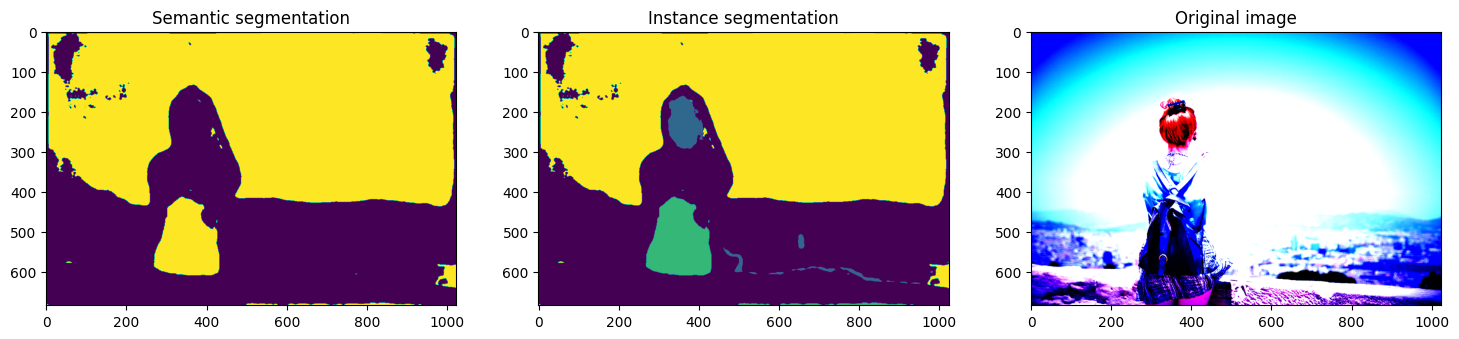

In [111]:
plt.figure(figsize=(18,10))
plt.subplot(1, 3, 1)
plt.title("Semantic segmentation")
plt.imshow(pred_semantics)
plt.subplot(1, 3, 2)
plt.title("Instance segmentation")
plt.imshow(pred_instance_map)
plt.subplot(1, 3, 3)
plt.title("Original image")
plt.imshow(image.transpose(1, 2, 0))
plt.show()

# Save and Load pth Model and Run Inference

In [115]:
pth_model = module.model
# save the pth model
save_path = 'model_weights/panoptic_model.pth'
torch.save(pth_model.state_dict(), save_path)

In [116]:
pth_model.load_state_dict(torch.load(save_path, map_location=torch.device("cpu")))

<All keys matched successfully>

In [117]:
def make_model(params):
    id2label = {0: "background", 1: "seedling"}
    config = Mask2FormerConfig.from_pretrained(params['model']['pretrained'])
    config.id2label = id2label
    config.label2id = {v:k for k,v in id2label.items()}
    config.num_queries = params['model']['num_queries']
    
    base_model = Mask2FormerModel.from_pretrained(params['model']['pretrained'], config=config, ignore_mismatched_sizes=True)
    base_model.config.num_queries = params['model']['num_queries']
    model = Mask2FormerForUniversalSegmentation(config)
    model.model = base_model
    if params['model']['ema_decay'] < 1.0:
        ema = ExponentialMovingAverage(model.model.parameters(),
                                       decay=params['model']['ema_decay'])
    return model

In [118]:
model = make_model(params)

Some weights of Mask2FormerModel were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-panoptic and are newly initialized because the shapes did not match:
- model.transformer_module.queries_embedder.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([300, 256]) in the model instantiated
- model.transformer_module.queries_features.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([300, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
model.load_state_dict(torch.load(save_path, map_location=torch.device("cpu")))

<All keys matched successfully>

In [120]:
pth_model.eval();

In [121]:
with torch.no_grad():
    out = pth_model(inputs['pixel_values'])

In [122]:
predictions = processor.post_process_panoptic_segmentation(out, 
                                                    #target_sizes=None,
                                                    target_sizes = [inputs['pixel_values'].shape[2:] for _ in range(len(inputs["pixel_values"]))], 
                                                    label_ids_to_fuse = [0],
                                                    threshold = params['inference']['threshold'],
                                                    mask_threshold = params['inference']['mask_threshold'],
                                                    overlap_mask_area_threshold = params['inference']['overlap_mask_area_threshold'],)

pred_instance_map = predictions[0]["segmentation"].cpu().numpy()
pred_semantics = torch.zeros(pred_instance_map.shape)
instance_ids = np.unique(pred_instance_map)
for instance_id in instance_ids:
    for class_info in predictions[0]["segments_info"]:
        if class_info["id"] == instance_id:
            pred_semantics[pred_instance_map == instance_id] = class_info["label_id"]
            break
pred_semantics[pred_semantics > 2] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


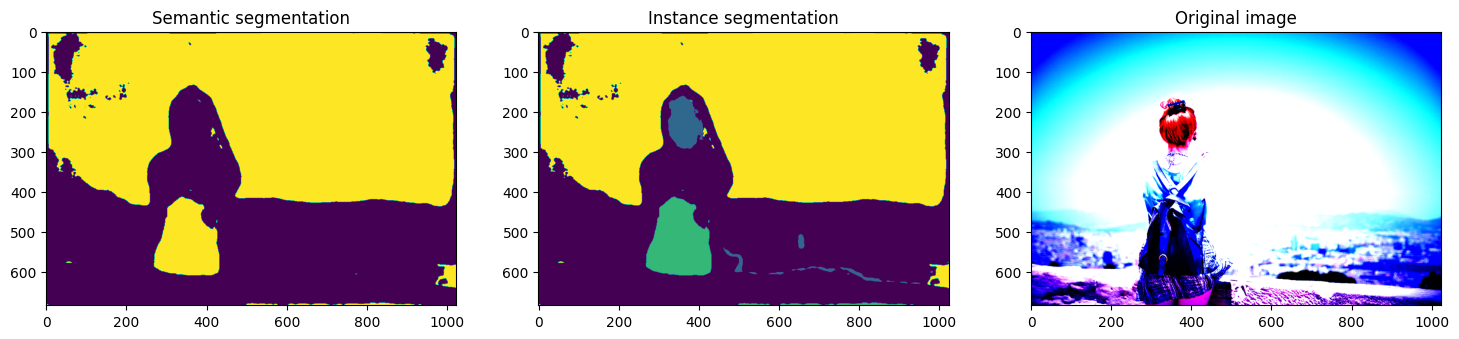

In [123]:
plt.figure(figsize=(18,10))
plt.subplot(1, 3, 1)
plt.title("Semantic segmentation")
plt.imshow(pred_semantics)
plt.subplot(1, 3, 2)
plt.title("Instance segmentation")
plt.imshow(pred_instance_map)
plt.subplot(1, 3, 3)
plt.title("Original image")
plt.imshow(image.transpose(1, 2, 0))
plt.show()

# Calculate Metrics

In [139]:
valid_root = params['data']['valid_root']
entries = os.listdir(valid_root)
# Filter out subdirectories
valid_dirs = [os.path.join(valid_root, entry) for entry in entries if os.path.isdir(os.path.join(valid_root, entry))]
val_dataset = SuperviselyPanopticDatasetNew(paths = valid_dirs, 
                                            processor=processor,
                                            transform=transforms)

Parsing ds8: 100%|██████████| 75/75 [00:00<00:00, 59793.35it/s]


In [140]:
len(val_dataset)

364

In [141]:
val_dataset[0].keys()

dict_keys(['pixel_values', 'pixel_mask', 'class_labels', 'mask_labels', 'image_name'])

# Log Folder, Run Inference to Multiple images

In [142]:
log_folder = params['logging']['output_folder']
os.makedirs(log_folder, exist_ok=True)
os.makedirs(f"{log_folder}/plant_instances", exist_ok=True)
os.makedirs(f"{log_folder}/semantics", exist_ok=True)
save_detections = False

In [150]:
pq = PanopticQuality()
iou = MulticlassJaccardIndex(num_classes=2, average=None)
mAP = MeanAveragePrecision(iou_type="segm")

In [151]:
len(val_dataset)

364

In [152]:
val_dataloader = DataLoader(val_dataset, 
                        batch_size = params['training']['batch_size'], 
                        shuffle = False, 
                        collate_fn = collate_fn, 
                        num_workers = params['data']['num_workers'])

In [153]:
#module.to('cuda');

In [159]:
img_path = 'data/supervisely-persons-DatasetNinja/ds1/img/city-woman-view-blue-sky.png' 
image = np.array(Image.open(img_path).convert("RGB"))
image = transforms(image=image)["image"]
image = image.transpose(2, 0, 1)
inputs = processor([image], return_tensors="pt")

In [162]:
pred_counts = []
gt_counts = []
counter = 0
for batch in tqdm.tqdm(val_dataloader):
    # Access the 'forward()' function from the 'module' object
    img_path = 'data/supervisely-persons-DatasetNinja/ds1/img/city-woman-view-blue-sky.png'  
    image = np.array(Image.open(img_path).convert("RGB"))
    image = transforms(image=image)["image"]
    image = image.transpose(2, 0, 1)
    inputs = processor([image], return_tensors="pt")
    inputs['pixel_values'] = batch['pixel_values']
    inputs['pixel_mask'] = batch['pixel_mask']
    with torch.no_grad():
        #inputs.to("cuda")
        inputs["mask_labels"] = None
        inputs["class_labels"] = None
        outputs = module(inputs)
        
    predictions = processor.post_process_panoptic_segmentation(outputs,
                                                              target_sizes=[batch['pixel_values'].shape[2:] for _ in range(len(batch["pixel_values"]))],
                                                              label_ids_to_fuse=[0],
                                                              threshold=params['inference']['threshold'],
                                                              mask_threshold=params['inference']['mask_threshold'],
                                                              overlap_mask_area_threshold=params['inference']['overlap_mask_area_threshold'],)

    
    inst_gt = batch["mask_labels"][0]
    class_labels = batch["class_labels"][0]
    pred_instance_map = predictions[0]["segmentation"]
    pred_semantics = torch.zeros(pred_instance_map.shape, dtype=torch.int64)
    instance_ids = torch.unique(pred_instance_map)
    pred_counts.append(len(instance_ids))
    gt_counts.append(len(inst_gt)-1)
    for instance_id in instance_ids:
        for class_info in predictions[0]["segments_info"]:
            if class_info["id"] == instance_id:
                pred_semantics[pred_instance_map == instance_id] = class_info["label_id"]
                break
    pred_semantics[pred_semantics > 2] = 0
    gt_semantics = torch.zeros_like(pred_semantics)
    for inst, class_label in zip(inst_gt, class_labels):
        gt_semantics[inst > 0] = class_label
    gt_instance_map = torch.zeros_like(gt_semantics)
    for i, inst in enumerate(inst_gt):
        gt_instance_map[inst > 0] = i + 1
    if params['model']['mode'] == "panoptic":
        gt_instance_map -= 1
    pq.compute_pq(pred_semantics.cpu(), gt_semantics.cpu(), pred_instance_map.cpu(), gt_instance_map.cpu())
    iou.update(pred_semantics.cpu(), gt_semantics.cpu())
    
    preds = [
    dict(
        masks = pred_semantics.cpu().unsqueeze(0).to(torch.bool), #tensor([pred_instance_map.cpu()], dtype=torch.bool),
        scores=tensor([0.536]),
        labels=tensor([0]),
    )]
    target = [
    dict(
        masks= gt_semantics.cpu().unsqueeze(0).to(torch.bool), #tensor([gt_instance_map.cpu()], dtype=torch.bool),
        labels=tensor([0]),
    )]
    mAP.update(preds, target)

    
    if save_detections:
        cv2.imwrite(f"{log_folder}/plant_instances/{batch['image_name'][0]}", 
                    pred_instance_map.cpu().numpy().astype(np.uint64))
        cv2.imwrite(f"{log_folder}/semantics/{batch['image_name'][0]}",
                    pred_semantics.cpu().numpy().astype(np.uint64))
        
    # counter += 1
    # if counter == 10:
    #     break
    

  5%|▌         | 20/364 [02:14<38:30,  6.72s/it]


KeyboardInterrupt: 

In [ ]:
mAP.compute()

/home/stamtron/miniconda3/envs/myenv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


{'map': tensor(-1.),
 'map_50': tensor(-1.),
 'map_75': tensor(-1.),
 'map_small': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(-1.),
 'mar_10': tensor(-1.),
 'mar_100': tensor(-1.),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [40]:
# Checking if tensors are equal
are_equal = torch.equal(preds[0]['masks'], target[0]['masks'])

print("Are the tensors equal?", are_equal) 

Are the tensors equal? False


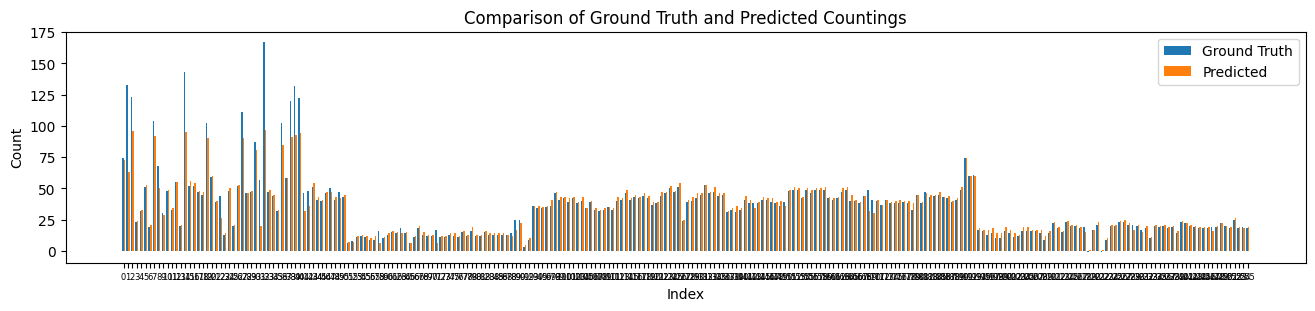

In [41]:
compare_countings(gt_counts, pred_counts, figsize=(16, 3), fontsize=6)

In [42]:
metrics = {}
metrics["IoU"] = {}
metrics["IoU"]["mean"] = round(float(iou.compute().mean()), 3)

pq_per_class = pq.panoptic_qualities
metrics["PQ"] = {}
metrics["PQ"]["mean"] = round(pq.average_pq(pq_per_class), 3)

metrics["mAP"] = {}
metrics["mAP"]["mean"] = round(float(mAP.compute()['map_50']), 3)


print(metrics)

{'IoU': {'mean': 0.942}, 'PQ': {'mean': 0.873}, 'mAP': {'mean': 0.986}}


In [43]:
# Convert to JSON
json_data = json.dumps(metrics, indent=2)
save_json_path = 'metrics/metrics_lettuce.json'
# Save to a file
with open(save_json_path, 'w') as json_file:
    json_file.write(json_data)

print("Data saved to metrics.json")

Data saved to metrics.json


In [44]:
# old metrics:
# {'IoU': {'mean': 0.755}, 'PQ': {'mean': 0.595}, 'mAP': {'mean': 0.674}}

# Visualization Function

In [45]:
valid_root = params['data']['valid_root']
entries = os.listdir(valid_root)
# Filter out subdirectories
valid_dirs = [os.path.join(valid_root, entry) for entry in entries if os.path.isdir(os.path.join(valid_root, entry))]
val_dataset = SuperviselyPanopticDatasetNew(paths = valid_dirs, 
                                            processor=processor,
                                            transform=transforms)

Parsing 20231002_bolchrysant: 100%|██████████| 45/45 [00:00<00:00, 106936.93it/s]


In [46]:
pth_model.to('cpu');

In [47]:
index = 87
with torch.no_grad():
    out = pth_model(val_dataset[index]['pixel_values'].unsqueeze(0).cpu())

In [48]:
inputs = processor([val_dataset[index]['pixel_values'].cpu()], return_tensors="pt")

In [49]:
predictions = processor.post_process_panoptic_segmentation(out, 
                                                    #target_sizes=None,
                                                    target_sizes = [inputs['pixel_values'].shape[2:] for _ in range(len(inputs["pixel_values"]))], 
                                                    label_ids_to_fuse = [0],
                                                    threshold = 0.2, #params['inference']['threshold'],
                                                    mask_threshold = 0.2, #params['inference']['mask_threshold'],
                                                    overlap_mask_area_threshold = 0.1 )#params['inference']['overlap_mask_area_threshold'],)

pred_instance_map = predictions[0]["segmentation"].cpu().numpy()
pred_semantics = torch.zeros(pred_instance_map.shape)
instance_ids = np.unique(pred_instance_map)
for instance_id in instance_ids:
    for class_info in predictions[0]["segments_info"]:
        if class_info["id"] == instance_id:
            pred_semantics[pred_instance_map == instance_id] = class_info["label_id"]
            break
pred_semantics[pred_semantics > 2] = 0

In [50]:
img = val_dataset[index]['pixel_values'].numpy()

In [51]:
img.shape

(3, 576, 1024)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


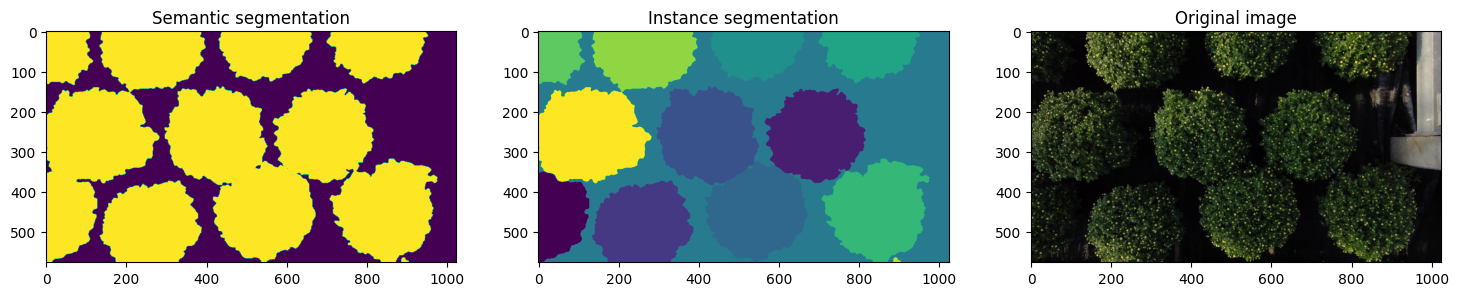

In [52]:
plt.figure(figsize=(18,10))
plt.subplot(1, 3, 1)
plt.title("Semantic segmentation")
plt.imshow(pred_semantics.cpu())
plt.subplot(1, 3, 2)
plt.title("Instance segmentation")
plt.imshow(pred_instance_map) #.cpu()
plt.subplot(1, 3, 3)
plt.title("Original image")
image = denormalize_image(params, img)
plt.imshow(image.transpose(1, 2, 0))
plt.show()

In [53]:
masks = pred_semantics

In [54]:
image = val_dataset[index]['pixel_values'].numpy()

In [55]:
masks.shape

torch.Size([576, 1024])

In [56]:
image.shape

(3, 576, 1024)

In [57]:
np.unique(masks)

array([0., 1.], dtype=float32)

In [58]:
masks = pred_instance_map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/tasos/miniconda3/envs/deep/lib/python3.11/site-packages/skimage/color/colorlabel.py:128: UserWarning: Negative intensities in `image` are not supported
  rgb = _label2rgb_overlay(label, image, colors, alpha, bg_label,


(3, 576, 1024)
(3, 576, 1024)


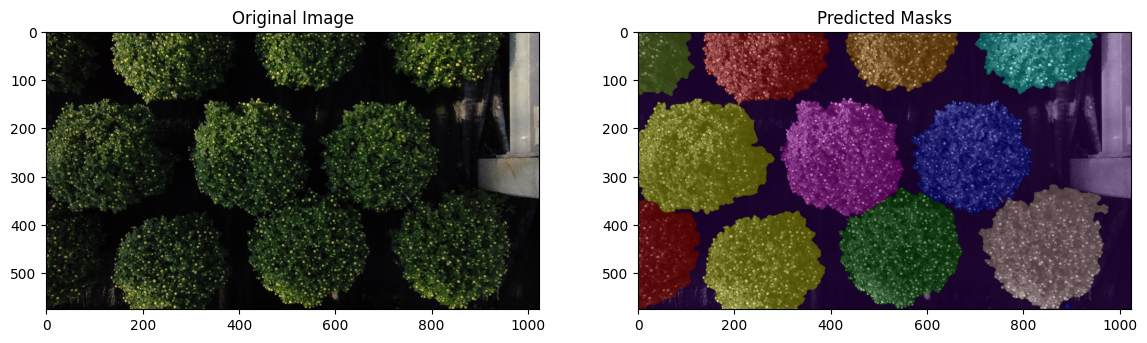

In [59]:
visualize_predicted_masks(params, image, masks)

In [60]:
len(np.unique(masks))

13